In [2]:
#一番いいモデル

In [5]:
import numpy as np
import gensim
import requests
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
import pandas as pd
from wikipedia2vec import Wikipedia2Vec
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
#dataのインポート+シャッフル
data = pd.read_csv("3.add_features_data.csv").sample(frac=1, random_state=1).reset_index(drop=True)
# 欠損値は最頻値補完を行う
def fill_na_mean(data):
    data.loc[:,"sim_by_mcg"] = data.loc[:,"sim_by_mcg"].fillna(data.loc[:,"sim_by_mcg"].mode()[0])
    data.loc[:,"is_a_by_mcg"] = data.loc[:,"is_a_by_mcg"].fillna(data.loc[:,"is_a_by_mcg"].mode()[0])
    data.loc[:,"wiki2vec_sim"] = data.loc[:,"wiki2vec_sim"].fillna(data.loc[:,"wiki2vec_sim"].mode()[0])
    data.loc[:,"wiki2vec_diff"] = data.loc[:,"wiki2vec_diff"].fillna(data.loc[:,"wiki2vec_diff"].mode()[0])
    return data
data = fill_na_mean(data)
#クラスラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
def label_encorder(data):
    le = LabelEncoder()
    encoded = le.fit_transform(data['relation'].values)
    decoded = le.inverse_transform(encoded)
    data.loc[:,'relation_label'] = encoded
    print(str(data["relation"].unique())+","+str(le.transform(data["relation"].unique())))
    return data
data = label_encorder(data)
#特徴量の選別 wn_sim_jcnは値がバグっているので使わない(infinityが入っている)
X_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup",
                "is_include_word","bert_sim","lexvec_diff","wiki2vec_diff","bert_diff"]
X_data = data.loc[:,X_columns]
# yの定義
y = data.loc[:,"relation_label"].values.astype("int32")

['s1' 'h2' 'h1' 's2' 'k'],[3 1 0 4 2]


In [7]:
X_data.columns

Index(['sim_by_mcg', 'is_a_by_mcg', 'lexvec_sim', 'wiki2vec_sim',
       'wn_hu_average', 'wn_pu_average', 'wn_sim_path', 'wn_sim_wup',
       'is_include_word', 'bert_sim', 'lexvec_diff', 'wiki2vec_diff',
       'bert_diff'],
      dtype='object')

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#通常の特徴量ラベル
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]

#diffラベルのpca_ssモデル trainとtest arrを返す
def ss_pca(train,pca_n):
    scaler = StandardScaler()
    train=scaler.fit_transform(train)
    pca = PCA(n_components = pca_n)
    train = pca.fit_transform(train)
    return train

In [9]:
#str_arrをarrに変換
def convert_to_arr(vec_str):
    vec_arr = None
    for s in vec_str:
        if vec_arr is None:
            vec_arr =np.array(s[1:-1].split(", ")).astype("float32")
        else:
            vec_arr = np.block([[vec_arr],[np.array(s[1:-1].split(", ")).astype("float32")]])
    return vec_arr

In [23]:
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]
pca_di={"lexvec_diff":30,"wiki2vec_diff":30,"bert_diff":3}


#pca成分の生成
from sklearn.model_selection import StratifiedKFold,LeaveOneOut,KFold
from copy import deepcopy
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


skf = StratifiedKFold(n_splits=100,random_state = 0)#80
#cm = None #混合配列
acc = list()#acc配列

y_test_arr = None#testの記録
y_pred_arr = None#predの記録
count = 1
for train_idx, test_idx in skf.split(X_data,y):
    print(str(count)+"epoc")
    count += 1
    
    #diff系以外をarrayに入れる 
    X = X_data.loc[:,X_normal_columns].values.astype("float64").astype("float64")
    
    
    # ベクトル系カラムをpcaする
    for column, n in pca_di.items():
        vec_arr = convert_to_arr(X_data.loc[:,column])
        pca_arr = ss_pca(vec_arr,n)
        X = np.concatenate([X, pca_arr], 1)
        
    
    #分割
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx]
    y_test = y[test_idx]
    #print(X_train.shape)
    
    #XGBOOST
    model = xgb.XGBClassifier(n_estimators=1500,max_depth=25,learning_rate=0.01)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    #結果の保存
    #print(accuracy_score(y_test, y_pred))
    #acc.append(accuracy_score(y_test, y_pred))
    #cm_temp = confusion_matrix(y_pred, y_test)
    if y_test_arr is None:
        #cm = cm_temp
        y_test_arr  = y_test
        y_pred_arr = y_pred
    else:
        #cm = cm + cm_temp
        y_test_arr= np.append(y_test_arr,y_test)
        y_pred_arr= np.append(y_pred_arr,y_pred)
        



/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 86 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"


1epoc
2epoc
3epoc
4epoc
5epoc
6epoc
7epoc
8epoc
9epoc
10epoc
11epoc
12epoc
13epoc
14epoc
15epoc
16epoc
17epoc
18epoc
19epoc
20epoc
21epoc
22epoc
23epoc
24epoc
25epoc
26epoc
27epoc
28epoc
29epoc
30epoc
31epoc
32epoc
33epoc
34epoc
35epoc
36epoc
37epoc
38epoc
39epoc
40epoc
41epoc
42epoc
43epoc
44epoc
45epoc
46epoc
47epoc
48epoc
49epoc
50epoc
51epoc
52epoc
53epoc
54epoc
55epoc
56epoc
57epoc
58epoc
59epoc
60epoc
61epoc
62epoc
63epoc
64epoc
65epoc
66epoc
67epoc
68epoc
69epoc
70epoc
71epoc
72epoc
73epoc
74epoc
75epoc
76epoc
77epoc
78epoc
79epoc
80epoc
81epoc
82epoc
83epoc
84epoc
85epoc
86epoc
87epoc
88epoc
89epoc
90epoc
91epoc
92epoc
93epoc
94epoc
95epoc
96epoc
97epoc
98epoc
99epoc
100epoc


0.6868008948545862
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        87
           1       0.80      0.85      0.83        87
           2       0.55      0.51      0.53       101
           3       0.62      0.59      0.61        86
           4       0.68      0.66      0.67        86

    accuracy                           0.69       447
   macro avg       0.69      0.69      0.69       447
weighted avg       0.68      0.69      0.68       447



<AxesSubplot:>

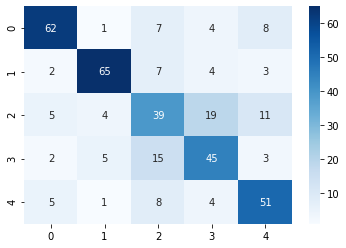

In [24]:
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
print(accuracy_score(y_test_arr, y_pred_arr))
print(classification_report(y_test_arr,y_pred_arr))
sns.heatmap(cm,annot=True, cmap='Blues')

In [ ]:
#result
import seaborn as sns

print(acc)
print(sum(acc)/len(acc))
print(max(acc)-(sum(acc)/len(acc)))
print(min(acc)-(sum(acc)/len(acc)))
sns.heatmap(cm,annot=True, cmap='Blues')
print("汎化"+str((cm[0,0]+cm[1,1])/np.sum(cm[:,0:2])))
print("関連"+str((cm[2,2])/np.sum(cm[:,2])))
print("集約"+str((cm[3,3]+cm[4,4])/np.sum(cm[:,3:5])))